In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
   Installed GR_jll ─────────────────────── v0.73.8+0
   Installed JpegTurbo_jll ──────────────── v3.0.4+0
   Installed libfdk_aac_jll ─────────────── v2.0.3+0
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed Libmount_jll ───────────────── v2.40.1+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed LERC_jll ───────────────────── v4.0.0+0
   Installed LoggingExtras ──────────────── v1.1.0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed Opus_jll ───────────────────── v1.3.3+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed Unitful ────────────────────── v1.21.0
   Installed ConcurrentUtilities ────────── v2.4.2
   Installed Measures ───────────────────── v0.3.2
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Grisu ──────────

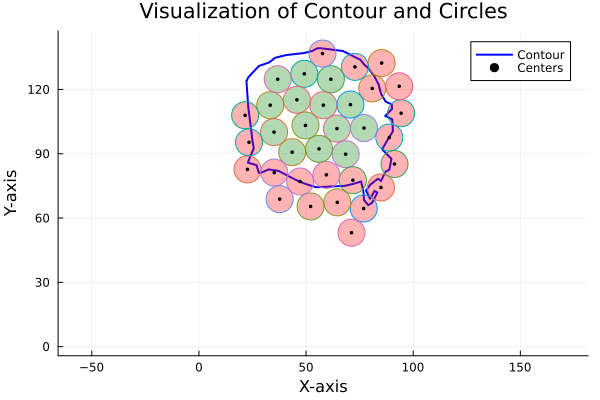

In [6]:
import Pkg; Pkg.add("Dierckx")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Optim")
Pkg.add("Statistics")
Pkg.add("Random")
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.25)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min

    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio

    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position

    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false

            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end

            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end

            attempts += 1
        end

        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle after $max_attempts attempts")
        end
    end

    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0
    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            if distance > 0
                circle_energy += distance^2
            else
                circle_energy += repulsion_penalty
            end
        end
    end

    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_strength = 1e6  # Strength of repulsion from the contour

    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center

        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if distance_to_boundary < 0 # Circle is touching or outside the boundary
                repell_energy += 1 / distance_to_boundary * repulsion_strength
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 2 * center_energy + 0 * repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        if circle_in_polygon(circle, smooth_x, smooth_y)
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
        else
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end

# Function to optimize the position of a single circle
function minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    function objective(params)
        updated_circles = deepcopy(circles)
        updated_circles[circle_index] = Circle(params[1], params[2], circles[circle_index].radius, circles[circle_index].label)
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    initial_params = [circles[circle_index].x_coord, circles[circle_index].y_coord]
    result = optimize(objective, initial_params, SimulatedAnnealing())
    optimized_params = Optim.minimizer(result)
    circles[circle_index] = Circle(optimized_params[1], optimized_params[2], circles[circle_index].radius, circles[circle_index].label)
end

# Function to iteratively optimize energy for random circles
function iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
    for _ in 1:num_iterations
        circle_index = rand(1:length(circles))
        minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    end
    return circles
end

# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 35
num_iterations = 200
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
optimized_circles = iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)


First 5 interpolated points:
θ = 0.0: (79.00000000000003, 66.00000000000001)
θ = 0.03157379551346526: (77.85337833266028, 67.04526311804254)
θ = 0.06314759102693052: (76.71689528744002, 67.24426538949498)
θ = 0.09472138654039577: (77.05842361453803, 68.87333010469307)
θ = 0.12629518205386103: (77.1072442420286, 70.81660659028057)
θ = 0.1578689775673263: (76.00316459028863, 71.97463797838185)
θ = 0.18944277308079155: (77.0795411888712, 73.08771872855542)
θ = 0.2210165685942568: (77.49280984850293, 74.65133613242085)
θ = 0.25259036410772207: (76.87904938741933, 76.18848941695607)
θ = 0.2841641596211873: (75.6485094864103, 77.15441816312341)
θ = 0.3157379551346526: (74.06738600592911, 77.05173437979343)
θ = 0.3473117506481178: (72.94536759375113, 75.98866771408595)
θ = 0.3788855461615831: (71.53380297796981, 75.6332692982146)
θ = 0.41045934167504833: (70.3181337254708, 74.80384165392788)
θ = 0.4420331371885136: (68.64661831678934, 75.07094590042509)
θ = 0.47360693270197884: (67.3616594691

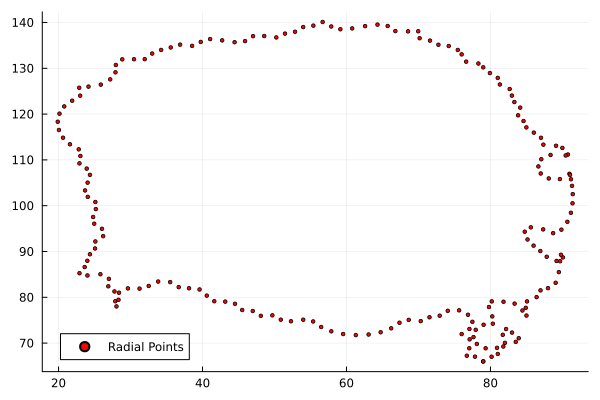

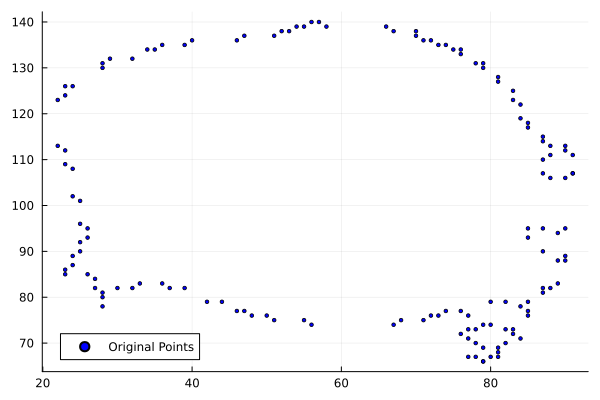

In [50]:
# Calculate centroid
centroid_x = mean(x)
centroid_y = mean(y)

# Calculate angles and distances for each point relative to centroid
θ = atan.(y .- centroid_y, x .- centroid_x)
r = sqrt.((x .- centroid_x).^2 + (y .- centroid_y).^2)


arclength = [0.0]
for i in 2:length(x)
    push!(arclength, arclength[end] + sqrt((x[i] - x[i-1])^2 + (y[i] - y[i-1])^2))
end

# Normalize arclength to [0, 2π]
total_arclength = arclength[end]
t = (arclength ./ total_arclength) .* 2π
t = t .+ range(0, stop=1e-6, length=length(t))  # Add small perturbation

# Create the splines using arclength as parameter
spline_x = Spline1D(t, x; k=3, periodic=true)  # Using arclength for parameterization
spline_y = Spline1D(t, y; k=3, periodic=true)  # Using arclength for parameterization

# Generate points along the curve using finer arclength values
t_fine = range(0, 2π, length=200)
x_interp = spline_x(t_fine)
y_interp = spline_y(t_fine)


# Print first few interpolated points
println("First 5 interpolated points:")
for i in 1:200
    println("θ = $(θ_fine[i]): ($(x_interp[i]), $(y_interp[i]))")
end

# Show the plot
display(scatter(x_interp, y_interp, label="Radial Points", color="red", markersize=2))
display(scatter(x, y, label="Original Points", color="blue", markersize=2))


In [55]:
Pkg.add("QuadGK")
using QuadGK

# Define the integrand function for Green's theorem
# f(t) = x(t)dy/dt - y(t)dx/dt
function integrand(t)
    x = spline_x(t)
    y = spline_y(t)
    dxdt = derivative(spline_x, t)
    dydt = derivative(spline_y, t)
    return x * dydt - y * dxdt
end

# Calculate area using QuadGK
# Area = 1/2 ∮ (x dy - y dx) = 1/2 ∫ (x dy/dt - y dx/dt) dt
area, error = quadgk(integrand, 0, 2π)  # Assuming parameterization is over [0, 2π]

# Take absolute value since orientation might give negative area
area = abs(area) * 0.5
println("Area enclosed by the curve: ", area)
println("Estimated error: ", error)

# Print a few values of the integrand for verification
println("\nIntegrand values at sample points:")
for t in [0, π/2, π, 3π/2]
    println("t = $t: $(integrand(t))")
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


Area enclosed by the curve: 3663.1789241576857
Estimated error: 0.0001078096391138512

Integrand values at sample points:
t = 0.0: 1673.574092613783
t = 1.5707963267948966: 4653.599576215723
t = 3.141592653589793: -6918.977696665589
t = 4.71238898038469: -2710.270440277268
